In [1]:
# from google.colab import drive
# drive.mount('/content/drive/')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb
from tensorflow import keras
from tensorflow.keras.layers import Input, Add
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import InputLayer, UpSampling2D, BatchNormalization

In [3]:
# Loading images
count_imgs = 50
imgs = []
for i in range(count_imgs):
    # for Google Colab Loading process
    # imgs.append(img_to_array(load_img("/content/dataset/color/" + str(i) + ".jpg", target_size=(256, 256))))
    
    # for Local env loading process
    imgs.append(img_to_array(load_img("./dataset/color/" + str(i) + ".jpg", target_size=(256, 256))))

imgs = np.array(imgs, dtype=float) / 255.0
labs = np.array([rgb2lab(rgb) for rgb in imgs])

# Split train and test data
split = int(0.9 * len(imgs))
trainSet, testSet = labs[:split], labs[split:]

# train and test dateset reshape
x_train = trainSet[:, :, :, 0]
x_train = x_train.reshape(x_train.shape + (1, ))
x_test = testSet[:, :, :, 0]
x_test = x_test.reshape(x_test.shape + (1, ))

y_train, y_test = trainSet[:, :, :, 1:] / 128.0, testSet[:, :, :, 1:] / 128.0    
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((45, 256, 256, 1), (45, 256, 256, 2), (5, 256, 256, 1), (5, 256, 256, 2))

In [4]:
# model autodecoder
input_0 = Input(shape=(256, 256, 1))

# down 1
con2d_d11 = Conv2D(2*8, (3, 3), activation='relu', padding='same')(input_0)
con2d_d12 = Conv2D(2*16, (3, 3), activation='relu', padding='same', strides=(2, 2))(con2d_d11)
bn_d1 = BatchNormalization()(con2d_d12) # 128 x 128

# down 2
con2d_d21 = Conv2D(2*16, (3, 3), activation='relu', padding='same')(bn_d1)
con2d_d22 = Conv2D(2*32, (3, 3), activation='relu', padding='same', strides=(2, 2))(con2d_d21)
bn_d2 = BatchNormalization()(con2d_d22) # 64

# down 3
con2d_d31 = Conv2D(2*32, (3, 3), activation='relu', padding='same')(bn_d2)
con2d_d32 = Conv2D(2*64, (3, 3), activation='relu', padding='same', strides=(2, 2))(con2d_d31)
bn_d3 = BatchNormalization()(con2d_d32) # 32

# down 4
con2d_d41 = Conv2D(2*64, (3, 3), activation='relu', padding='same')(bn_d3)
con2d_d42 = Conv2D(2*128, (3, 3), activation='relu', padding='same', strides=(2, 2))(con2d_d41)
bn_d4 = BatchNormalization()(con2d_d42) # 16

# same 1
con2d_s11 = Conv2D(2*128, (3, 3), activation='relu', padding='same')(bn_d4)
con2d_s12 = Conv2D(2*128, (3, 3), activation='relu', padding='same')(con2d_s11)
bn_s1 = BatchNormalization()(con2d_s12) # 

res_s1 = Add()([bn_d4, bn_s1])

# same 2
con2d_s21 = Conv2D(2*128, (3, 3), activation='relu', padding='same')(res_s1)
con2d_s22 = Conv2D(2*128, (3, 3), activation='relu', padding='same')(con2d_s21)
bn_s2 = BatchNormalization()(con2d_s22) # 

res_s2 = Add()([res_s1, bn_s2])

# same 3
con2d_s31 = Conv2D(2*128, (3, 3), activation='relu', padding='same')(res_s2)
con2d_s32 = Conv2D(2*128, (3, 3), activation='relu', padding='same')(con2d_s31)
bn_s3 = BatchNormalization()(con2d_s32) # 

res_s3 = Add()([res_s2, bn_s3])

# same 4
con2d_s41 = Conv2D(2*128, (3, 3), activation='relu', padding='same')(res_s3)
con2d_s42 = Conv2D(2*128, (3, 3), activation='relu', padding='same')(con2d_s41)
bn_s4 = BatchNormalization()(con2d_s42) # 

res_s4 = Add()([res_s3, bn_s4])

# up 1
us_u1 = UpSampling2D((2, 2))(res_s4)
con2d_u11 = Conv2D(2*64, (5, 5), activation='relu', padding='same')(us_u1)
con2d_u12 = Conv2D(2*64, (3, 3), activation='relu', padding='same')(con2d_u11)

# res_d_u_1 = Add()([bn_d3, con2d_u12])

# up 2
us_u2 = UpSampling2D((2, 2))(con2d_u12)
con2d_u21 = Conv2D(2*32, (5, 5), activation='relu', padding='same')(us_u2)
con2d_u22 = Conv2D(2*32, (3, 3), activation='relu', padding='same')(con2d_u21)

# res_d_u_2 = Add()([bn_d2, con2d_u22])

# up 3
us_u3 = UpSampling2D((2, 2))(con2d_u22)
con2d_u31 = Conv2D(2*16, (5, 5), activation='relu', padding='same')(us_u3)
con2d_u32 = Conv2D(2*16, (3, 3), activation='relu', padding='same')(con2d_u31)

# res_d_u_3 = Add()([bn_d1, con2d_u32])

# up 4
us_u4 = UpSampling2D((2, 2))(con2d_u32)
con2d_u41 = Conv2D(2*8, (5, 5), activation='relu', padding='same')(us_u4)
con2d_u42 = Conv2D(2*8, (3, 3), activation='relu', padding='same')(con2d_u41)

con2d_out = Conv2D(2, (1, 1), padding='same')(con2d_u42)

model = keras.Model(input_0, con2d_out)

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-05-12 21:47:14.033265: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-12 21:47:14.033401: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
model.compile(optimizer=keras.optimizers.Adam(), loss='mse', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 32  4640        ['conv2d[0][0]']                 
                                )                                                             

In [6]:
history = model.fit(x_train, y_train, batch_size=8, epochs=10)

Epoch 1/10


2022-05-12 21:47:14.512764: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-12 21:47:15.156979: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 3s 255ms/step - loss: 0.3112 - accuracy: 0.5200
Epoch 2/10
6/6 [==============================] - 1s 221ms/step - loss: 0.0158 - accuracy: 0.5282
Epoch 3/10
6/6 [==============================] - 1s 214ms/step - loss: 0.0146 - accuracy: 0.4582
Epoch 4/10
6/6 [==============================] - 1s 216ms/step - loss: 0.0116 - accuracy: 0.4736
Epoch 5/10
6/6 [==============================] - 1s 212ms/step - loss: 0.0105 - accuracy: 0.5200
Epoch 6/10
6/6 [==============================] - 1s 211ms/step - loss: 0.0099 - accuracy: 0.5027
Epoch 7/10
6/6 [==============================] - 1s 211ms/step - loss: 0.0095 - accuracy: 0.5759
Epoch 8/10
6/6 [==============================] - 1s 215ms/step - loss: 0.0095 - accuracy: 0.5815
Epoch 9/10
6/6 [==============================] - 1s 210ms/step - loss: 0.0093 - accuracy: 0.5334
Epoch 10/10
6/6 [==============================] - 1s 215ms/step - loss: 0.0092 - accuracy: 0.5320


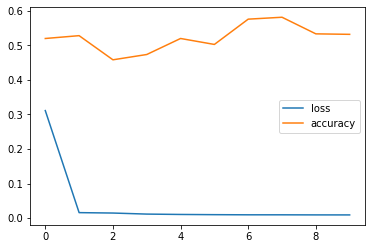

In [7]:
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["accuracy"], label="accuracy")
plt.legend()
plt.show()

In [12]:
y_pred = model.predict(x_test)
# y_pred = model.predict(x_train[:5])
y_pred.shape

(5, 256, 256, 2)

In [9]:
# y_pred_ab Reshape
y_pred_ab = y_pred * 128.0
y_pred_lab = np.zeros(testSet.shape)
for i in range(len(x_test)):
    y_pred_lab[i, :, :, 0] = x_test[i].reshape(x_test.shape[1:3])
    y_pred_lab[i, :, :, 1:] = y_pred_ab[i]

#  LAB to RGB
y_pred_rgb = [lab2rgb(lab) for lab in y_pred_lab]
# testSet_rgb = [lab2rgb(lab) for lab in testSet]
testSet_rgb = [lab2rgb(lab) for lab in testSet[0:20]]

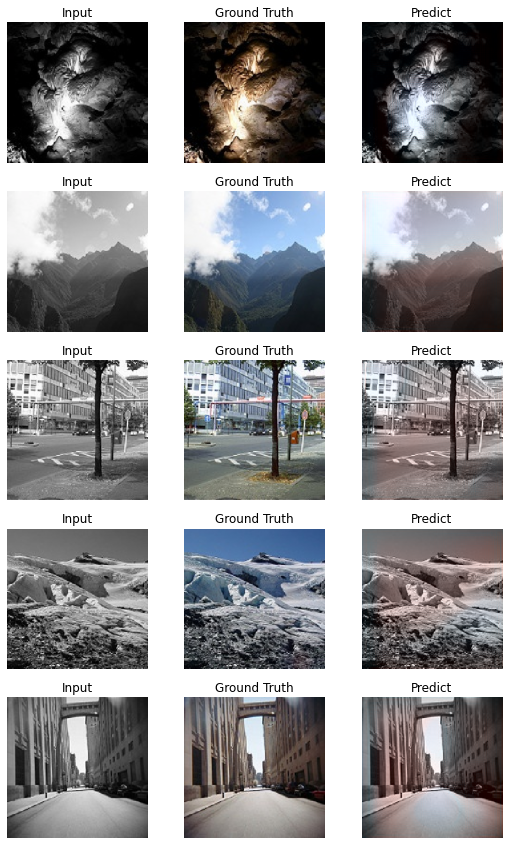

In [10]:
# print the result images
count = 1
n_sample = x_test.shape[0]
fig = plt.figure(figsize=(9, 3 * n_sample))
def extract_single_dim_from_LAB_convert_to_RGB(image, idim):
    z = np.zeros(image.shape)
    if idim != 0 : z[:, :, 0] = 80 # Brightness
    z[:, :, idim] = image[:, :, idim]
    z = lab2rgb(z)
    return z
for test_rgb, pred_rgb, test_lab in zip(testSet_rgb, y_pred_rgb, testSet):

    ax = fig.add_subplot(n_sample, 3, count)
    lab_rgb_gray = extract_single_dim_from_LAB_convert_to_RGB(test_lab, 0) 
    ax.imshow(lab_rgb_gray)
    ax.axis("off")
    ax.set_title("Input")
    count += 1
    
    ax = fig.add_subplot(n_sample, 3, count)
    ax.imshow(test_rgb)
    ax.axis("off")
    ax.set_title("Ground Truth")
    count += 1

    ax = fig.add_subplot(n_sample, 3, count)
    ax.imshow(pred_rgb)
    ax.axis("off")
    ax.set_title("Predict")
    count += 1
plt.show()

In [11]:
# Save model
# from datetime import date
# today = date.today()
# model.save('drive/MyDrive/model_final/' + str(today) + '_' + str(count_imgs))